![](full-intro.png)

# Narya

The Narya API allows you track soccer player from camera inputs, and evaluate them with an Expected Discounted Goal (EDG) Agent. This repository contains the implementation of the [following paper](https://). We also make available all of our pretrained agents, and the datasets we used as well. 

The goal of this Notebook is to allow anyone without any access to soccer data to produce its own and to analyse them with powerfull tools. We also hope that by releasing our training procedures and datasets, better models will emerge and make this tool better iteratively. 

# Framework 

Our library is split in 2: one part is to track soccer players, another one is to process these trackings and evalute them. Let's start by focusing on how to track soccer players.

# Installation

You can either install narya from source:

```git clone && cd narya && pip3 install -r requirements.txt```

Let's start by importing some libraries and an image we will use during this notebook: 

In [1]:
!pip3 install --user tensorflow==2.2.0
!pip3 install --user tensorflow-probability==0.11.0
!pip3 install --user dm-sonnet=2.0.0

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from narya.utils.vizualization import visualize

Image shape: (1024, 1024, 3)


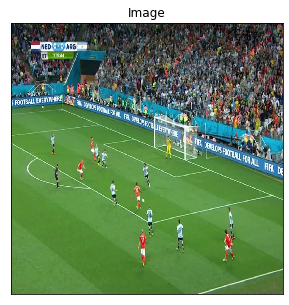

In [2]:
image = cv2.imread('test_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape: {}".format(image.shape))
visualize(image=image)

## Tracking Soccer Players

![](tracker_full.png)

### Players detections

The Player Detection model : $\mathbb{R} ^ {n \times n \times 3} \to \mathbb{R} ^ {m \times 4} \times \left[0,1\right] ^ {m} \times \left[0,1\right] ^ {m}$, takes an image as input, and predicts a list of bounding boxes associated with a class prediction (Player or Ball) and a confidence value. The model is based on a Single Shot MultiBox Detector (SSD) {cite}`Liu_2016`, with an implementation from GluonCV {cite}`gluoncvnlp2020`.
 
You can easily:
* Load the model
* Load weights for this model 
* Call this model 

We tried to keep a similar architecture for each model, even with different framework.
For example, each model deals on itself with image pre-processing, reshaping and so on: a simple ```__call__``` is enough.

Let's start by importing a tracking model:

In [3]:
from narya.models.gluon_models import TrackerModel
from gluoncv.utils import viz
import tensorflow as tf

tracker_model = TrackerModel(pretrained=True, backbone='ssd_512_resnet50_v1_coco')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


and load our pretrained weights: 

**Note:** When a ```TrackerModel``` gets instanciate more than once, weights won't load succesfully. Make sure to restart the kernel in this case

In [4]:
WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_tracker.params"
)
WEIGHTS_NAME = "player_tracker.params"
WEIGHTS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

tracker_model.load_weights(checkpoints)

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_tracker.params


You can now easily use this model to make predictions on any soccer related images. Let's try it on our example:

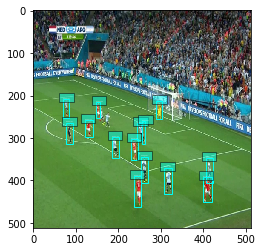

In [6]:
cid, score, bbox = tracker_model(image, split_size = 512)
ax = viz.plot_bbox(cv2.resize(image,(512,512)), bbox[0], score[0], cid[0], class_names=tracker_model.model.classes,thresh=0.5,linewidth=1,fontsize=1)
plt.show()

Now that we have players' coordinates (and the ball position), we need to be able to transform these coordinates into 2D coordinates. This means finding the homography between our input image, and a 2D representation of the field: 

![](homography-estimation.png)

### Homography Estimations

We developped 2 methods to ensure more robust estimations of the current homography. The first one is a direct prediction, and the second one computes the homography from the detection of some particular keypoints. Let's start with the direct prediction: $\mathbb{R} ^ {n \times n \times 3} \to \mathbb{R} ^ {3 \times 3}$. 

The model is based on a Resnet-18 architecture {cite}`he2015deep` and takes images of shape $(280,280)$. It was implemented with Keras. Let's review it's architecture, which is kept the same for each model no matter its framework. 

Each model is created with:
* The shape of its input
* If we want it pretrained or not

It then creates a model and a preprocessing function:

```python3
class DeepHomoModel:
    """Class for Keras Models to predict the corners displacement from an image. These corners can then get used 
    to compute the homography.

    Arguments:
        pretrained: Boolean, if the model is loaded pretrained on ImageNet or not
        input_shape: Tuple, shape of the model's input 
    Call arguments:
        input_img: a np.array of shape input_shape
    """

    def __init__(self, pretrained=False, input_shape=(256, 256)):

        self.input_shape = input_shape
        self.pretrained = pretrained

        self.resnet_18 = _build_resnet18()

        inputs = tf.keras.layers.Input((self.input_shape[0], self.input_shape[1], 3))
        x = self.resnet_18(inputs)
        outputs = pyramid_layer(x, 2)

        self.model = tf.keras.models.Model(
            inputs=[inputs], outputs=outputs, name="DeepHomoPyramidalFull"
        )

        self.preprocessing = _build_homo_preprocessing(input_shape)
```

Each model then has the same call function: 

```python3
def __call__(self, input_img):

    img = self.preprocessing(input_img)
    corners = self.model.predict(np.array([img]))

    return corners
```

Let's apply this direct homography estimation to our example. This can be done easily, exactly like the tracking model: 

In [8]:
from narya.models.keras_models import DeepHomoModel

deep_homo_model = DeepHomoModel()

WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/deep_homo_model.h5"
)
WEIGHTS_NAME = "deep_homo_model.h5"
WEIGHTS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

deep_homo_model.load_weights(checkpoints)

corners = deep_homo_model(image)

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/deep_homo_model.h5


Let's load a "template" image, a 2D view of the field. This is the image to which we will apply our predicted homography: 

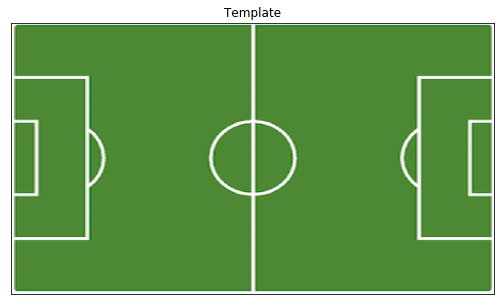

In [10]:
template = cv2.imread('world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template)

and let's make it easier to display on another image: 

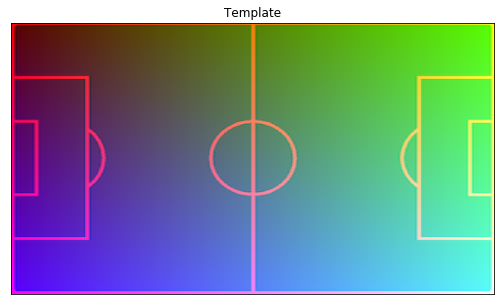

In [11]:
from narya.utils.vizualization import rgb_template_to_coord_conv_template

template = rgb_template_to_coord_conv_template(template)
visualize(template=template)

Now, let's import some utils functions, and warp our template with our predicted homography:

Predicted homography: [[ 3.3973143e-01 -1.2927253e-03  4.6077079e-01]
 [ 3.0281174e-01  1.7163661e+00  4.9089849e-02]
 [ 4.1546736e-02  1.5496995e+00  1.0000000e+00]]
--------------------


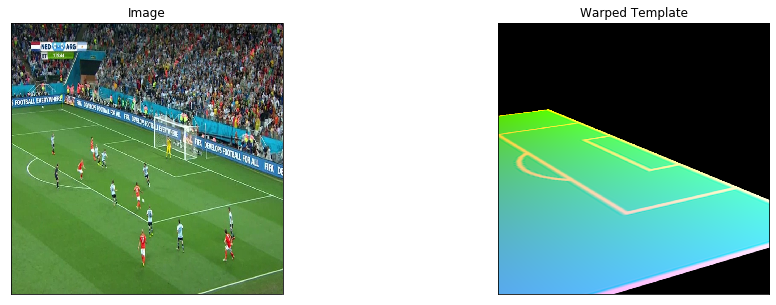

In [13]:
from narya.utils.homography import compute_homography, warp_image,warp_point
from narya.utils.image import torch_img_to_np_img, np_img_to_torch_img, denormalize
from narya.utils.utils import to_torch

pred_homo = compute_homography(corners)[0]
print("Predicted homography: {}".format(pred_homo))
print('-'*20)
pred_warp = warp_image(np_img_to_torch_img(template),to_torch(pred_homo),method='torch')
pred_warp = torch_img_to_np_img(pred_warp[0])
visualize(image=image,warped_template=cv2.resize(pred_warp, (1024,1024)))

You can also merge the warped template with your example: 

**Notes**: Usually, this homography is only used to compute the coordinates of each players.

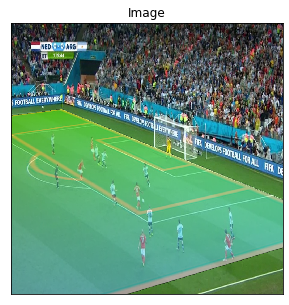

In [14]:
from narya.utils.vizualization import merge_template

test = merge_template(image/255.,cv2.resize(pred_warp, (1024,1024)))
visualize(image = test)

Our second approach is based on keypoints detection: $\mathbb{R} ^ {n \times n \times 3} \to \mathbb{R} ^ {p \times n \times n}$ we predict $p$ masks, each mask representing a particular keypoint on the field. The homography is computed knowing the coordinates of available keypoints on the image, by mapping them to the keypoints coordinates of the 2-dimensional field. The model is based on an EfficientNetb-3 backbone {cite}`tan2019efficientnet` on top of a Feature Pyramid Networks (FPN) {cite}`lin2016feature` architecture to predict the mask of each keypoint. We implemented our model using Segmentation Models {cite}`Yakubovskiy:2019`.

Again, let's start by quickly creating our model and making some predictions: 

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/keypoint_detector.h5


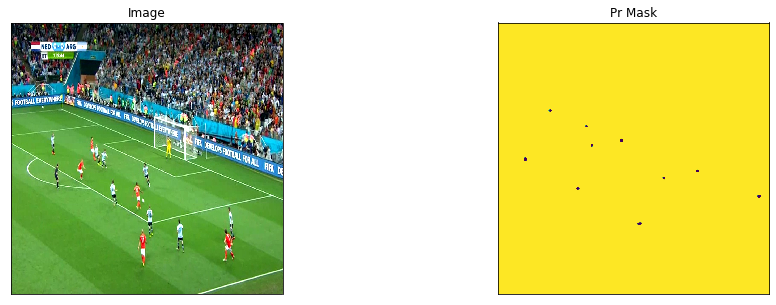

In [15]:
from narya.models.keras_models import KeypointDetectorModel

kp_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5"
)
WEIGHTS_NAME = "keypoint_detector.h5"
WEIGHTS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

kp_model.load_weights(checkpoints)

pr_mask = kp_model(image)
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., -1].squeeze(),
    )

Here, we display a concatenation of each keypoints we predicted. Now, since we know the "true" coordinates of each of them, we can precisely compute the parameters of the related homography. 

**Notes**: We explain here how the homography parameters are computed. This is a Supplementary Material from our paper and therefore, can be skipped.

We assume 2 sets of points $(x_1,y_1)$ and $(x_2,y_2)$ both in $\mathbb{R}^2$, and define $\mathbf{X_i}$ as $[x_i,y_i,1]^{\top}$. We define the planar homography $\mathbf{H}$ that relates the transformation between the 2 planes generated by $\mathbf{X_1}$ and $\mathbf{X_2}$ as : 

\begin{align*}
    \mathbf{X_2} = \mathbf{H}\mathbf{X_1} =  \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} \mathbf{X_1}
\end{align*}

where we assume $h_{33} = 1$ to normalize $\mathbf{H}$ and since $\mathbf{H}$ only has $8$ degrees of freedom as it estimates only up to a scale factor. The equation above yields the following 2 equations: 

\begin{align*}
    x_2 = \frac{h_{11}x_1 + h_{12}y_1 + h_{13}}{h_{31}x_1 + h_{32}y_1 + 1} 
    \\
    y_2 = \frac{h_{21}x_1 + h_{22}y_1 + h_{23}}{h_{31}x_1 + h_{32}y_1 + 1} 
\end{align*}

that we can rewrite as : 

\begin{align*}
    x_2 = h_{11}x_1 + h_{12}y_1 + h_{13} - h_{31}x_1x_2 - h_{32}y_1x_2
\end{align*}
\begin{align*}
    y_2 = h_{21}x_1 + h_{22}y_1 + h_{23} - h_{31}x_1y_2 - h_{32}y_1y_2
\end{align*}

or more concisely:

\begin{equation*}
    \begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_2 & -y_1x_2 \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_2 & -y_1y_2   \end{bmatrix} \mathbf{h} = 0
\end{equation*}

where $\mathbf{h} = [h_{11},h_{12},h_{13},h_{21},h_{22},h_{23},h_{31},h_{32}]^{\top}$. We can stack such constraints for $n$ pair of points, leading to a system of equations of the form $\mathbf{A}\mathbf{h} = 0$ where $\mathbf{A}$ is a $2n \times 8$ matrix. Given the $8$ degrees of freedom and the system above, we need at least $8$ points (4 in each plan) to compute an estimation of our homography. 

This is the method we use to compute the homography fomr the keypoints prediction.

Let's do it and predict an homography from these keypoints: 

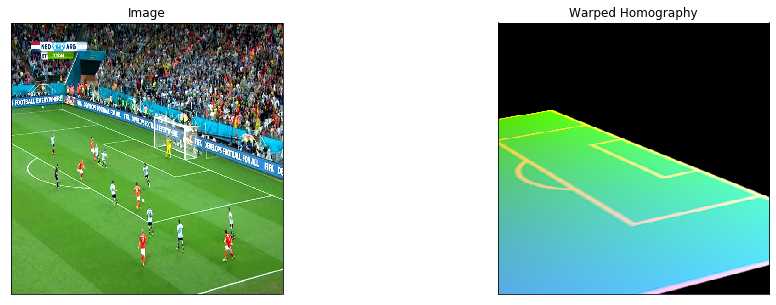

In [17]:
from narya.utils.masks import _points_from_mask 
from narya.utils.homography import get_perspective_transform

src,dst = _points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))
visualize(
        image=denormalize(image.squeeze()),
        warped_homography=pred_warp,
    )

and if we merge them: 

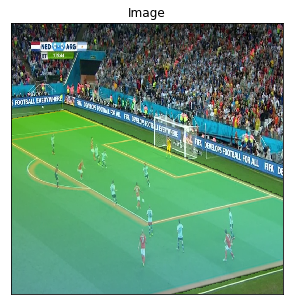

In [18]:
test = merge_template(image/255.,cv2.resize(pred_warp, (1024,1024)))
visualize(image = test)

### ReIdentification

Finally, we need to be able to say if one player from frame is the same in another frame. We use 3 tools to do so: 

- a Kalman filter, to remove outliers
- the IoU distance, to ensure that one person cannot move too much in 2 consecutives frames
- the cosine similarity between embeddings

Our last model deals with the embedding part. Once again, even as a torch model, it can be loaded and used like the rest.

Let's start by cropping the image of a player:

71 85 208 252


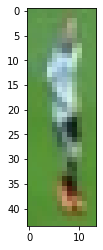

In [21]:
x_1 = int(bbox[0][0][0])
y_1 = int(bbox[0][0][1])
x_2 = int(bbox[0][0][2])
y_2 = int(bbox[0][0][3])
print(x_1,x_2,y_1,y_2)

resized_image = cv2.resize(image,(512,512))
plt.imshow(resized_image[y_1:y_2,x_1:x_2])

Now, we can create and call our model: 

In [23]:
from narya.models.torch_models import ReIdModel

reid_model = ReIdModel()

WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_reid.pth"
)
WEIGHTS_NAME = "player_reid.pth"
WEIGHTS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

reid_model.load_weights(checkpoints)

player_img = resized_image[y_1:y_2,x_1:x_2]
embedding = reid_model(player_img)

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_reid.pth


In [24]:
embedding[0].shape

(751,)

In the next section, we will see how to use all of these models together to track players on a video